## Random Forest Playground
This code references [this tutorial](https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/) on AV. Also, this on [medium](https://towardsdatascience.com/random-forest-ca80e56224c1).

some findings:
- when splitting by zero fatalities / one or more fatalities, the dataset was split almost exactly 50-50. the oob score was around 0.63 and the best oob score was with (max_depth=20, min_samples_leaf=10, n_estimators=200), which achieved a oob score of 0.645.
- when splitting by less than 10 / 10 or more fatalities, the dataset was split 92-8, basically. oob score was about 0.9212, which is the same as guessing. best was 0.9219 with (max_depth=10, min_samples_leaf=5, n_estimators=30)

In [1]:
# Importing the required libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

### read and clean data

In [51]:
df = pd.read_csv("../data/acled/south_sudan.csv")
df.columns

Index(['EVENT_ID_CNTY', 'EVENT_DATE', 'YEAR', 'TIME_PRECISION',
       'DISORDER_TYPE', 'EVENT_TYPE', 'SUB_EVENT_TYPE', 'ACTOR1',
       'ASSOC_ACTOR_1', 'INTER1', 'ACTOR2', 'ASSOC_ACTOR_2', 'INTER2',
       'INTERACTION', 'CIVILIAN_TARGETING', 'ISO', 'REGION', 'COUNTRY',
       'ADMIN1', 'ADMIN2', 'ADMIN3', 'LOCATION', 'LATITUDE', 'LONGITUDE',
       'GEO_PRECISION', 'SOURCE', 'SOURCE_SCALE', 'NOTES', 'FATALITIES',
       'TAGS', 'TIMESTAMP'],
      dtype='object')

In [52]:
selected_columns = ['LATITUDE', 'LONGITUDE', 'FATALITIES', 'TIMESTAMP']
df_short = df[selected_columns].copy()
df_short.head()

,LATITUDE,LONGITUDE,FATALITIES,TIMESTAMP
0,6.209,31.559,0,1696268002
1,6.209,31.559,2,1696268002
2,6.180,31.811,1,1696268002
3,3.850,31.657,0,1696268002
4,4.452,34.188,0,1696268002


In [54]:
df_short['FATAL'] = (df_short['FATALITIES'] > 10).astype(int)
df_short['FATAL'].value_counts()

FATAL
0    8474
1     752
Name: count, dtype: int64

In [55]:
cleaned = df_short.drop(['FATALITIES'], axis=1)
cleaned.head()

,LATITUDE,LONGITUDE,TIMESTAMP,FATAL
0,6.209,31.559,1696268002,0
1,6.209,31.559,1696268002,0
2,6.180,31.811,1696268002,0
3,3.850,31.657,1696268002,0
4,4.452,34.188,1696268002,0


In [56]:
X = cleaned.drop('FATAL',axis=1)
y = cleaned['FATAL']

In [57]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((6458, 3), (2768, 3))

### train the random forest classifier

In [58]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

%time
classifier_rf.fit(X_train, y_train)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.15 µs


RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [59]:
# https://www.analyticsvidhya.com/blog/2022/11/out-of-bag-oob-score-for-bagging-in-data-science/#:~:text=The%20prediction%20error%20on%20that,score%20for%20the%20bottom%20model.

# Out of Bag Error
classifier_rf.oob_score_


0.9211830288014865

In [60]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

from sklearn.model_selection import GridSearchCV

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

%time
grid_search.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [61]:
grid_search.best_score_

0.9219572548252327

In [62]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=30,
                       n_jobs=-1, random_state=42)

### visualize the results

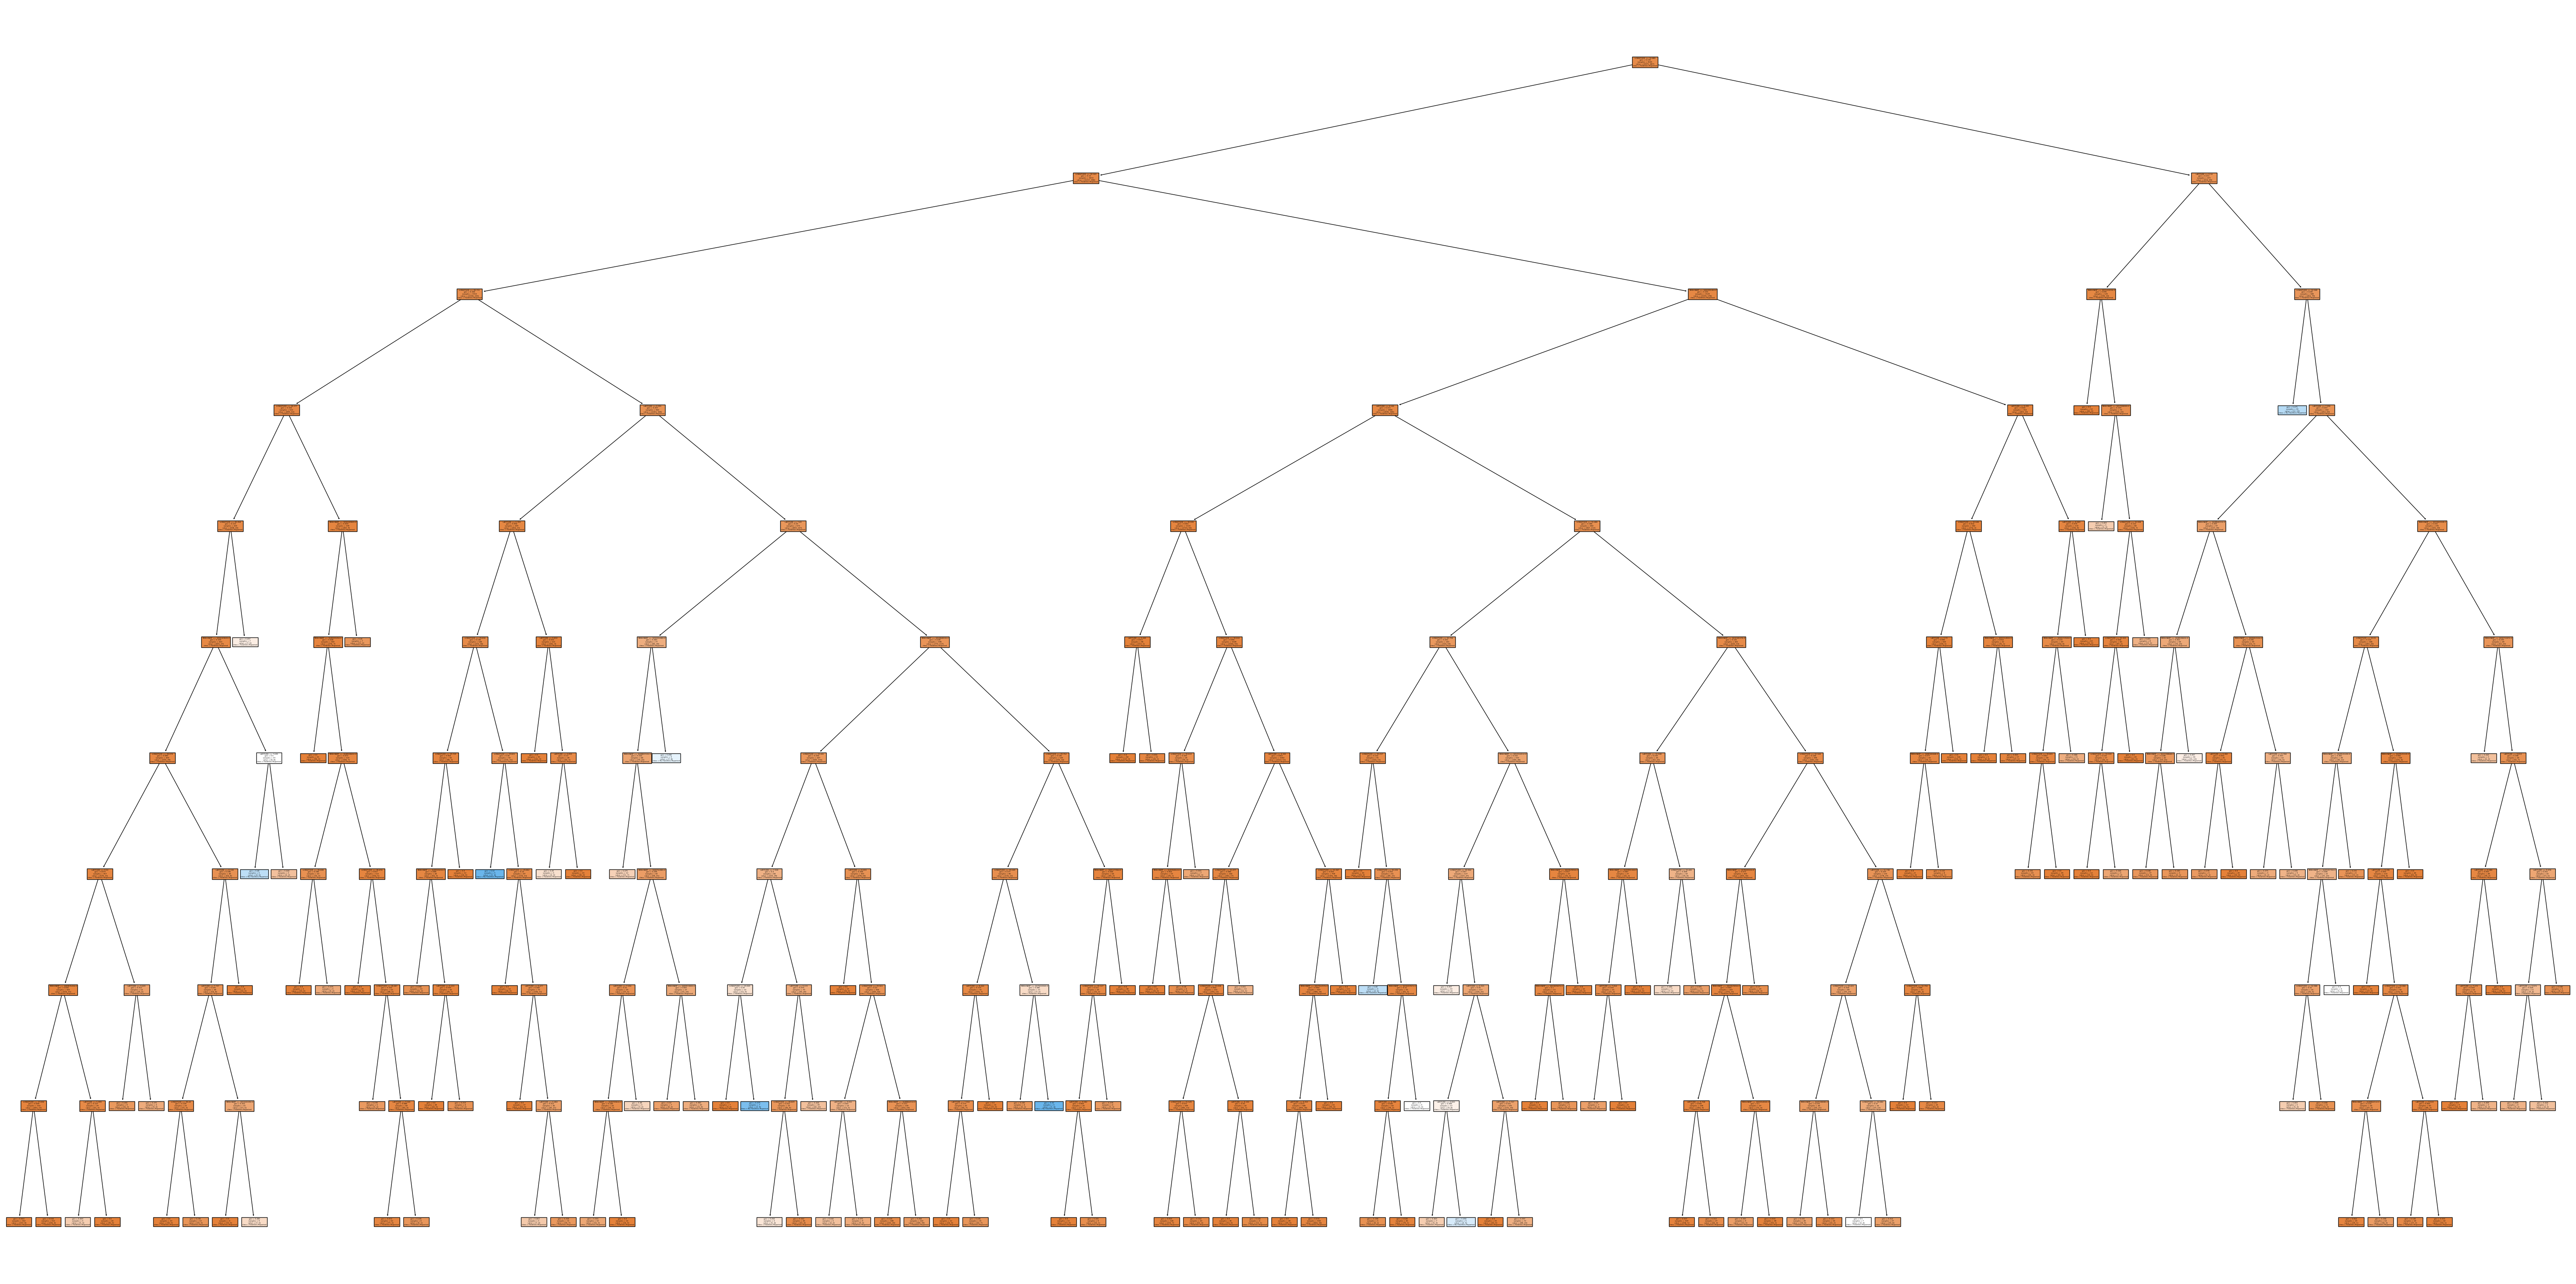

In [63]:
from sklearn.tree import plot_tree

plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[5], feature_names = X.columns,class_names=['Fatalities Reported', "No Fatalities Reported"],filled=True);

In [64]:
imp_df = pd.DataFrame({
    "variable name": X_train.columns,
    "importance": rf_best.feature_importances_
})

imp_df.sort_values(by="importance", ascending=False)

,variable name,importance
0,LATITUDE,0.355753
1,LONGITUDE,0.348341
2,TIMESTAMP,0.295907


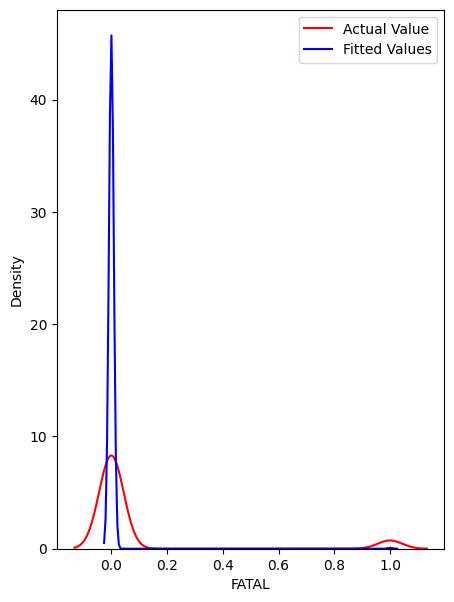

In [65]:
import seaborn as sns
y_pred = rf_best.predict(X_test)

plt.figure(figsize=(5, 7))
# Plotting actual values
sns.kdeplot(y, color="r", label="Actual Value")
# Plotting predicted values
sns.kdeplot(y_pred, color="b", label="Fitted Values")

plt.legend()
plt.show()